In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length "{length}" bytes'.format(name=fn, length = len(uploaded[fn])))

!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length "69" bytes


In [4]:
!kaggle datasets download -d ahmedhamada0/brain-tumor-detection

 86% 72.0M/84.0M [00:00<00:00, 227MB/s]
100% 84.0M/84.0M [00:00<00:00, 228MB/s]


In [5]:
from zipfile import ZipFile
file_name = "/content/brain-tumor-detection.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print("Unzipped")


Unzipped


In [6]:
# Import required libraries
import tensorflow as tf
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  """


In [7]:
os.chdir('/content/yes')
X = []
y = []
for i in tqdm(os.listdir()):
  img = cv2.imread(i)
  img = cv2.resize(img, (224,224))
  X.append(img)
  # 0 indicates tumor is present
  y.append(0)
os.chdir('/content/no')
for i in tqdm(os.listdir()):
  img = cv2.imread(i)
  img = cv2.resize(img, (224,224))
  X.append(img)
  # 1 indicates tumor is NOT present
  y.append(1)
# for i in range(0,99):
#   y.append('N')


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/1500 [00:00<?, ?it/s]

In [8]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 42)
print("Shape of image in X train = ", X_train[0].shape)
print("Shape of image in X test = ", X_test[0].shape)

Shape of image in X train =  (224, 224, 3)
Shape of image in X test =  (224, 224, 3)


In [9]:
import numpy as np
le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)

In [10]:
print("X_train shape = ",X_train.shape)
print("X_test shape = ",X_test.shape)
print("y_train shape = ",y_train.shape)
print("y_test shape = ",y_test.shape)

X_train shape =  (2010, 224, 224, 3)
X_test shape =  (990, 224, 224, 3)
y_train shape =  (2010, 2)
y_test shape =  (990, 2)


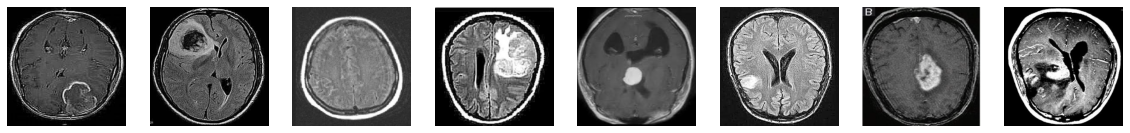

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20,20))
for i in range(8):
  plt.subplot(1,8,i+1)
  plt.imshow(X[i], cmap='gray')
  plt.axis('off')
plt.show()

In [12]:
from keras.applications import InceptionV3

# The imagenet dataset which was used to train the inception model had more than 1000 classes
# In our dataset, we have only 2 classes
# Thus, we remove the top layers from the model
img_rows, img_cols = 224,224
inception = InceptionV3(weights = 'imagenet', include_top = False, input_shape = (img_rows, img_cols,3))

#Freeze the last 4 layers
# Freeze the bottom layers since we don't want to train the model from scratch. 
for layer in inception.layers:
  layer.trainable = False

#Print layers
for (i,layer) in enumerate(inception.layers):
  print(str(i) + " "+layer.__class__.__name__, layer.trainable)


0 InputLayer False
1 Conv2D False
2 BatchNormalization False
3 Activation False
4 Conv2D False
5 BatchNormalization False
6 Activation False
7 Conv2D False
8 BatchNormalization False
9 Activation False
10 MaxPooling2D False
11 Conv2D False
12 BatchNormalization False
13 Activation False
14 Conv2D False
15 BatchNormalization False
16 Activation False
17 MaxPooling2D False
18 Conv2D False
19 BatchNormalization False
20 Activation False
21 Conv2D False
22 Conv2D False
23 BatchNormalization False
24 BatchNormalization False
25 Activation False
26 Activation False
27 AveragePooling2D False
28 Conv2D False
29 Conv2D False
30 Conv2D False
31 Conv2D False
32 BatchNormalization False
33 BatchNormalization False
34 BatchNormalization False
35 BatchNormalization False
36 Activation False
37 Activation False
38 Activation False
39 Activation False
40 Concatenate False
41 Conv2D False
42 BatchNormalization False
43 Activation False
44 Conv2D False
45 Conv2D False
46 BatchNormalization False
47 Batc

In [13]:
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense, MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras import regularizers
def lw(bottom_model, num_classes):
  # Create the top of the model which was removed. 
  # This will be placed on top of the model
  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024, activation='relu')(top_model)
  top_model = Dense(512, activation='relu')(top_model)
  top_model = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(top_model)
  top_model = Dense(num_classes, activation = 'softmax')(top_model)
  return top_model


In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model

num_classes = 2

FC_Head = lw(inception, num_classes)
model = Model(inputs=inception.input, outputs = FC_Head)
#model = Model(inputs=vgg16.input, outputs = FC_Head)
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [15]:
model.compile(optimizer='adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [16]:
history = model.fit(X_train, y_train, epochs = 8, validation_data=(X_test,y_test), verbose = 1, initial_epoch=0)

Epoch 1/8
63/63 [==============================] - 331s 5s/step - loss: 5.8078 - accuracy: 0.6139 - val_loss: 1.9836 - val_accuracy: 0.6879
Epoch 2/8
63/63 [==============================] - 322s 5s/step - loss: 1.5553 - accuracy: 0.7731 - val_loss: 1.3707 - val_accuracy: 0.8010
Epoch 3/8
63/63 [==============================] - 324s 5s/step - loss: 1.3607 - accuracy: 0.8045 - val_loss: 1.1993 - val_accuracy: 0.8414
Epoch 4/8
63/63 [==============================] - 322s 5s/step - loss: 1.1128 - accuracy: 0.8557 - val_loss: 1.0949 - val_accuracy: 0.8566
Epoch 5/8
63/63 [==============================] - 318s 5s/step - loss: 1.1010 - accuracy: 0.8373 - val_loss: 1.0279 - val_accuracy: 0.8616
Epoch 6/8
63/63 [==============================] - 321s 5s/step - loss: 0.9752 - accuracy: 0.8736 - val_loss: 0.9685 - val_accuracy: 0.8455
Epoch 7/8
63/63 [==============================] - 318s 5s/step - loss: 0.8697 - accuracy: 0.8965 - val_loss: 0.8573 - val_accuracy: 0.8939
Epoch 8/8
63/63 [===

In [17]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("inception_model.h5")

In [18]:
model.save('/content/inception_model', save_format = 'h5')

In [19]:
# It can be used to reconstruct the model identically.
from tensorflow import keras
reconstructed_model = keras.models.load_model("inception_model.h5")

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
y_pred = reconstructed_model.predict(X_test)
#ypred = np.array([1 if x > 0.5 else 0 for x in ypred])
#ypred = ypred.astype(int)
y_pred=np.argmax(y_pred, axis=1)
y_test=np.argmax(y_test, axis=1)
print('Confusion_Matrix:\n',confusion_matrix(y_test, y_pred))
print('\nClassification_report:\n',classification_report(y_pred,y_test))

31/31 [==============================] - 118s 4s/step
Confusion_Matrix:
 [[398 110]
 [ 15 467]]

Classification_report:
               precision    recall  f1-score   support

           0       0.78      0.96      0.86       413
           1       0.97      0.81      0.88       577

    accuracy                           0.87       990
   macro avg       0.88      0.89      0.87       990
weighted avg       0.89      0.87      0.87       990



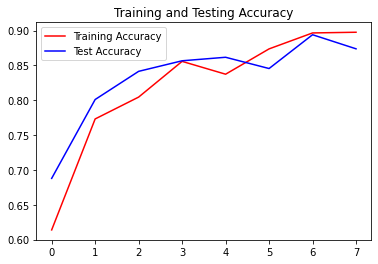

<Figure size 432x288 with 0 Axes>

In [21]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
validation_acc = history.history['val_accuracy']
loss = history.history['loss']
validation_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, validation_acc, 'b', label = 'Test Accuracy')

plt.title("Training and Testing Accuracy")

plt.legend(loc=0)

plt.figure()

plt.show()